In [134]:
from scipy.integrate import solve_ivp 
from numpy import linspace, array
from scipy.optimize import fsolve 
from matplotlib import pyplot as plt
import numpy

From investigation 2

In [135]:
steam_eb_molar_ratio, n_tubes, Di, To, Length = [27.3, 1356.53, 35.6/1000, 939, 6.5] #Units = Di [mm], To[K], Length[m]
A_cross = (numpy.pi*Di**2)/4 #m2

In [136]:
Po_original = 2.4*101325 #Pa
Ua = 100/60 #kJ/m3/s/K
Tu = 1000 #K
print('Po =', Po_original/1000, 'kPa')

Po = 243.18 kPa


Inlet flowartes

In [137]:
F_EBo = 0.00344 #kmol/s
F_St = F_EBo*steam_eb_molar_ratio #kmol/s
Fto = (F_St + F_EBo) #kmol/s

Constants

In [138]:
V = 10 #m3
dp = 1/1000 #m
pc = 2137 #kg/m3
por = 0.4
pb = pc*(1-por) #kg/m3

W = V*pc #kg

R = 8.314 #kJ/kmol/K

MM_EB = 106#.167 kg/kmol
MM_St = 18 #kg/kmol
Avg_inlet_MM = (F_EBo/(Fto))*MM_EB + (F_St/(Fto))*MM_St #kg/kmol


muEB = 0.669*10**-3 #Pa.s X
muSt = 0.029*10**-3 #500 degC and 200 kPa X
mu = (F_EBo/(F_St+F_EBo))*muEB + (F_St/(F_St+F_EBo))*muSt #Pa.s

K_ergun calculation

In [139]:
m_eb = F_EBo*MM_EB #kg/s
m_steam = F_St*MM_St #kg/s

mass_flowrate = Avg_inlet_MM*Fto#kg/s
G = mass_flowrate/A_cross/n_tubes #kgpertube/m2/s
def K_ergun(Po):
  po = Avg_inlet_MM*(Po/1000)/(R*To) #kg/m3 X
  return (G/(po*dp))*((1-por)/por**3)*(150*mu*(1-por)/dp + 1.75*G) # Pa/m
print('K_ergun =', K_ergun(Po_original), 'Pa/m')
K_ergun_original = K_ergun(Po_original)
print('Due to the relatively high amount of inert this Ergun constant will result in a pressure drop of',numpy.round(K_ergun(Po_original)*Length/1000, 2), 'kPa over the PBR. For this reason, the inlet Pressure must be increased.') 

K_ergun = 158594.85278669972 Pa/m
Due to the relatively high amount of inert this Ergun constant will result in a pressure drop of 1030.87 kPa over the PBR. For this reason, the inlet Pressure must be increased.


Increasing the inlet pressure will increasing the inital density, which will decrease the Ergun constant, and thus it follows that the pressure drop will decrease.

Po optimisation

Approach 1: Solve for an inlet pressure by specifying the minimum pressure out

In [140]:
Pout_min = 101325 #Pa
def event_1_atm(Po):
    po = Avg_inlet_MM*(Po/1000)/(R*To) #kg/m3
    return Po - K_ergun(Po)*Length - Pout_min
Po_new = numpy.round(fsolve(event_1_atm, 5*101325),0)
print('Po =', Po_new[0]/1000, 'kPa')
print('Pressure drop =', numpy.round(K_ergun(Po_new)[0]*Length/1000, 2), 'kPa')
print('P_out =', Po_new[0]/1000 - numpy.round(K_ergun(Po_new)[0]*Length/1000, 2), 'kPa' )
print('The Ergun constant for this Po is', K_ergun(Po_new)[0], 'Pa/m')

Po = 553.905 kPa
Pressure drop = 452.58 kPa
P_out = 101.32499999999999 kPa
The Ergun constant for this Po is 69627.63705088354 Pa/m


As can be seen above, Approach 1 results in a very high pressure drop over the reactor. 

Approach 2: Solve for an inlet pressure by specifying the maximum pressure drop

In [141]:
CpM = 68
CpE = 90
CpB = 201
CpT = 249
CpSty = 273
CpEB = 299
CpH = 30
CpSt = 40
delCp1 = -CpEB + CpSty + CpH
delCp2 = -CpEB + CpB + CpE
delCp3 = -CpEB - CpH + CpT + CpM

In [142]:
delHrx1_ref = 118000
delHrx2_ref = 105200
delHrx3_ref = -53900

b1 = -17.34
b2 = -1.302*10**4
b3 = 5.051
b4 = -2.314*10**-10
b5 = 1.302*10**-6
b6 = -4.931*10**-3

In [143]:
def DE(W, var):
  F_M, F_E, F_B, F_T, F_Sty, F_EB, F_H, T, P, K_ergun = var

  Ft = F_M + F_E + F_B + F_T + F_Sty + F_EB + F_H + F_St
  P_in_atm = P/101325
  P_Sty = F_Sty*P_in_atm/Ft
  P_EB = F_EB*P_in_atm/Ft
  P_H = F_H*P_in_atm/Ft

  k1 = numpy.exp(-0.08539 - 10925/T)
  Kp1 = numpy.exp(b1 + b2/T + b3*numpy.log(T) + ((b4*T + b5)*T + b6)*T) #atm
  rSty1 = pb*k1*(P_EB - P_Sty*P_H/Kp1) #kmol/m3/s

  k2 = numpy.exp(13.2392 - 25000/T)
  rB2 = pb*k2*P_EB #kmol/m3/s

  k3 = numpy.exp(0.2961 - 11000/T)
  rT3 = pb*k3*P_EB*P_H #kmol/m3/s

  rEB1 = -rSty1 
  rEB2 = - rB2 
  rEB3 = - rT3


  dFMdW = rT3/pb
  dFEdW = rB2/pb
  dFBdW = rB2/pb
  dFTdW = rT3/pb
  dFStydW = rSty1/pb
  dFEBdW = (-rSty1 - rB2 - rT3)/pb
  dFHdW = (rSty1 - rT3)/pb

  delHrx1 = delHrx1_ref + delCp1*(T-298)
  delHrx2 = delHrx2_ref + delCp2*(T-298)
  delHrx3 = delHrx3_ref + delCp3*(T-298)

  dPdW = -K_ergun*Po*Ft*T/(P*Fto*To)/A_cross/pb #Pa/kg
  dPodW = 0

  sum_Fi_Cpi = F_M*CpM + F_E*CpE + F_B*CpB + F_T*CpT + F_Sty*CpSty + F_EB*CpEB + F_H*CpH + F_St*CpSt
  dTdW = (-rEB1*delHrx1 - rEB2*delHrx2 - rEB3*delHrx3 - Ua*(1000-T))/-sum_Fi_Cpi/pb 
  
  return dFMdW, dFEdW, dFBdW, dFTdW, dFStydW, dFEBdW, dFHdW, dTdW, dPdW, dPodW

This next section explores styrene production as a function of different Ergun constants. The constants was calculated at the original and inlet pressure from Approach 1 but initial pressures of Approach 2 (see at end) was used for the differential equation to stay consistent.

[158.59498439 158.59498439 158.59498439 158.59498439 158.59498439
 158.59498439 158.59498439 158.59498439 158.59498439 158.59498439
 158.59498439 158.59498439 158.59498439 158.59498439 158.59498439
 158.59498439 158.59498439 158.59498439 158.59498439 158.59498439
 158.59498439 158.59498439 158.59498439 158.59498439 158.59498439
 158.59498439 158.59498439 158.59498439 158.59498439 158.59498439
 158.59498439 158.59498439 158.59498439 158.59498439 158.59498439
 158.59498439 158.59498439]


array([0.        , 0.18154018, 1.87164368, 5.0973123 , 5.23427267,
       5.27073639, 5.27399102, 5.27770229, 5.28146336, 5.27927946,
       5.2775651 , 5.27728611, 5.27727154, 5.27726764, 5.27726498,
       5.27726476, 5.2772646 , 5.27726455, 5.27726451, 5.27726451,
       5.2772645 , 5.2772645 , 5.2772645 , 5.2772645 , 5.2772645 ,
       5.2772645 , 5.2772645 , 5.2772645 , 5.2772645 , 5.2772645 ,
       5.2772645 , 5.2772645 , 5.2772645 , 5.2772645 , 5.2772645 ,
       5.2772645 , 5.2772645 ])

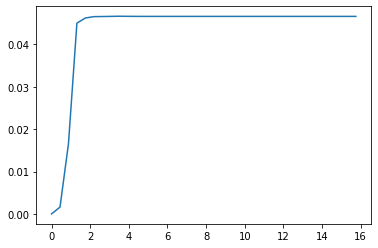

In [144]:
#K_ergun_range = [Kergun_original, Kergun Approach 1)] (Kergun_original>Kergun_approach 1)
#Po in Approach 2 was manually solved as 23.65 atm for which W_cat per tube will have 200 kPa P-drop
Po = 101325*23.65
Start = [0, 0, 0, 0, 0, F_EBo/n_tubes, 0, To, Po, K_ergun(Po_original)]
Wspan = numpy.linspace(0,W/n_tubes,37)
Out = solve_ivp(DE, (0,W/n_tubes), Start, dense_output = True)
Sty = Out.y[4]*n_tubes
Tol = Out.y[3][-1]*n_tubes
Ben = Out.y[2][-1]*n_tubes
H = Out.y[6][-1]*n_tubes
selec = Sty/(Tol+Ben)
#print(selec, Sty[-1]*1000, Tol*1000, Ben*1000, H*1000)

F_M, F_E, F_B, F_T, F_Sty, F_EB, F_H, T, P, Po = Out.sol(Wspan)
P = Out.y[8][-1]
print(Po/1000-P/1000)
plt.plot(Wspan, Sty*1000)
Sty_original = Sty*1000
selec

5.271631583042476 0.08741654282391062 7.187094777725183e-07 0.016581726677090562 0.08741582411443287
1066.5717044748355


/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ivp/base.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


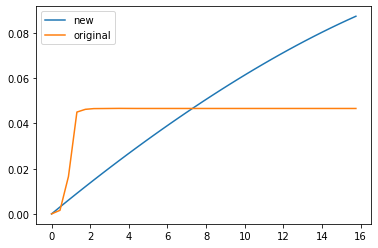

In [145]:
Po = 101325*23.65
Start = [0, 0, 0, 0, 0, F_EBo/n_tubes, 0, To, Po, K_ergun(Po_new)]
Wspan = numpy.linspace(0,W/n_tubes,37)
Out = solve_ivp(DE, (0,W/n_tubes), Start, dense_output = True)
Sty = Out.y[4][-1]*n_tubes
Tol = Out.y[3][-1]*n_tubes
Ben = Out.y[2][-1]*n_tubes
H = Out.y[6][-1]*n_tubes
selec = Sty/(Tol+Ben)
print(selec, Sty*1000, Tol*1000, Ben*1000, H*1000)
P = Out.y[8][-1]
print(Po/1000-P/1000)
F_M, F_E, F_B, F_T, F_Sty, F_EB, F_H, T, P, Po = Out.sol(Wspan)
Sty_new = F_Sty*n_tubes*1000
plt.plot(Wspan,Sty_new)
plt.plot(Wspan,Sty_original)
plt.legend(['new','original'])

Code for Approach 2:

In [146]:
def DE(W, var):
  F_M, F_E, F_B, F_T, F_Sty, F_EB, F_H, T, P, Po = var

  Ft = F_M + F_E + F_B + F_T + F_Sty + F_EB + F_H + F_St
  P_in_atm = P/101325
  P_Sty = F_Sty*P_in_atm/Ft
  P_EB = F_EB*P_in_atm/Ft
  P_H = F_H*P_in_atm/Ft

  k1 = numpy.exp(-0.08539 - 10925/T)
  Kp1 = numpy.exp(b1 + b2/T + b3*numpy.log(T) + ((b4*T + b5)*T + b6)*T) #atm
  rSty1 = pb*k1*(P_EB - P_Sty*P_H/Kp1) #kmol/m3/s

  k2 = numpy.exp(13.2392 - 25000/T)
  rB2 = pb*k2*P_EB #kmol/m3/s

  k3 = numpy.exp(0.2961 - 11000/T)
  rT3 = pb*k3*P_EB*P_H #kmol/m3/s

  rEB1 = -rSty1 
  rEB2 = - rB2 
  rEB3 = - rT3


  dFMdW = rT3/pb
  dFEdW = rB2/pb
  dFBdW = rB2/pb
  dFTdW = rT3/pb
  dFStydW = rSty1/pb
  dFEBdW = (-rSty1 - rB2 - rT3)/pb
  dFHdW = (rSty1 - rT3)/pb

  delHrx1 = delHrx1_ref + delCp1*(T-298)
  delHrx2 = delHrx2_ref + delCp2*(T-298)
  delHrx3 = delHrx3_ref + delCp3*(T-298)

  dPdW = -K_ergun(Po)*Po*Ft*T/(P*Fto*To)/A_cross/pb #Pa/kg
  dPodW = 0

  sum_Fi_Cpi = F_M*CpM + F_E*CpE + F_B*CpB + F_T*CpT + F_Sty*CpSty + F_EB*CpEB + F_H*CpH + F_St*CpSt
  dTdW = (-rEB1*delHrx1 - rEB2*delHrx2 - rEB3*delHrx3 - Ua*(1000-T))/-sum_Fi_Cpi/pb 
  
  return dFMdW, dFEdW, dFBdW, dFTdW, dFStydW, dFEBdW, dFHdW, dTdW, dPdW, dPodW

In [147]:
def PSTOP(W, var):
  F_M, F_E, F_B, F_T, F_Sty, F_EB, F_H, T, P, Po = var
  return Po - 200000 - P

In [148]:
#Po in Approach 2 was manually solved as 23.65 atm for which W_cat per tube will have 200 kPa P-drop
print(W/n_tubes)

15.753429706678068


In [149]:
Po = 101325*23.65
Start = [0, 0, 0, 0, 0, F_EBo/n_tubes, 0, To, Po, Po]
Out = solve_ivp(DE, [0,W/n_tubes], Start, events = PSTOP, dense_output = True)
W_cat = Out.t_events[0][0]
Wrange = (0,W_cat)
Wspan = numpy.linspace(0,W_cat,37)
Out = solve_ivp(DE, Wrange, Start, events = PSTOP, dense_output = True)
F_M, F_E, F_B, F_T, F_Sty, F_EB, F_H, T, P, Po = Out.sol(Wspan)
W_cat
print((Po/1000-P/1000)[-1])

200.00000000018235


In [150]:
#The Ergun constant for this approach is 
print(K_ergun(101325*23.65), 'Pa/m')

16094.192248967416 Pa/m


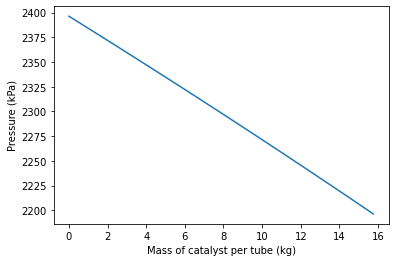

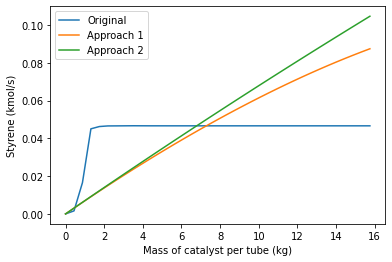

5.270479548044609

In [151]:
Sty = Out.y[4][-1]*n_tubes
Tol = Out.y[3][-1]*n_tubes
Ben = Out.y[2][-1]*n_tubes
H = Out.y[6][-1]*n_tubes
selec = Sty/(Tol+Ben)
plt.plot(Wspan,P/1000)
plt.xlabel('Mass of catalyst per tube (kg)')
plt.ylabel('Pressure (kPa)')
plt.show()
plt.plot(Wspan,Sty_original)
plt.plot(Wspan,Sty_new)
plt.plot(Wspan, F_Sty*1000*n_tubes)#, F_T, F_B, F_H)
plt.xlabel('Mass of catalyst per tube (kg)')
plt.ylabel('Styrene (kmol/s)')

plt.legend(['Original','Approach 1','Approach 2', ])
#plt.plot(Wspan, F_T*1000*n_tubes))#, F_B, F_H)
plt.show()

selec

original ergun constant very large: concentration becomes so low that reaction stops 2 kg down reactor


Selectivities and flowrates for styrene, toluene, benzene and hydrogen for different K_ergun constants were printed below

In [152]:
 #=[5.27044573489527, 0.02558022430691441, 1.8981650122431302e-08, 0.004853503015085268, 0.025580205325264276] #Pin = 23.65 atm
No_P_drop =[5.270249397518096, 0.10904810080925462, 1.4923479187845177e-06, 0.020689767701483872, 0.10463100056240475]
Approach_2 =[5.270479548044609, 0.10463230005920261, 1.2994967979073683e-06, 0.019851220393545286, 0.10463100056240475] #200 kPa drop Pin = 23 atm
#Selectivity, FSty, FTol, FBen =[5.270478138372576 0.10464252661571906 1.299742966034911e-06 0.01985316580425862 0.10464122687275305] Koriginal Pin = 23 atm
#Selectivity, FSty, FTol, FBen =[5.280666750360767, 0.00570757536432149, 6.074981523691482e-10, 0.001080843087842319, 0.005707574756823337]  Knew from (Approach 1) but w Pin = 23 atm
print(Approach_2[1]/No_P_drop[1])
print(Approach_2[2]/No_P_drop[2])
print(Approach_2[3]/No_P_drop[3])
print(Approach_2[4]/No_P_drop[4])

0.9595059362127172
0.8707733508723474
0.959470433886097
1.0


Text(0, 0.5, 'Pressure (kPa)')

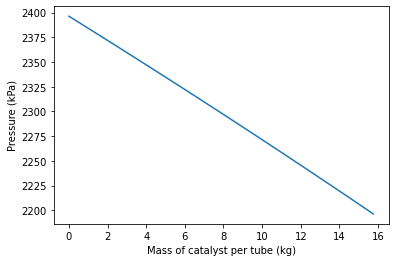

In [153]:
plt.plot(Wspan,P/1000)
plt.xlabel('Mass of catalyst per tube (kg)')
plt.ylabel('Pressure (kPa)')